# RIPE ATLAS Data Analysis

In [2]:
import duckdb
import pandas as pd
import json
import matplotlib.pyplot as plt
import numpy as np

In [3]:
con = duckdb.connect(database='data/duck.db')

In [4]:
cdata = con.sql("SELECT DISTINCT country FROM ping_data;").df()
countries = cdata["country"].to_list()
msmsdata = con.sql("SELECT DISTINCT msm_id FROM ping_data WHERE msm_id < 10000;").df() # Built-In Measurements have an ID of less than 10'000
built_in_msms = msmsdata["msm_id"].to_list()

In [5]:
data = con.sql("SELECT SUM(sent_packets) FROM ping_data WHERE msm_id > 10000 GROUP BY msm_id;")
print(data)

┌───────────────────┐
│ sum(sent_packets) │
│      int128       │
├───────────────────┤
│           2114294 │
└───────────────────┘



In [6]:
data = con.sql("SELECT SUM(received_packets) FROM ping_data WHERE msm_id > 10000 GROUP BY msm_id;")
print(data)

┌───────────────────────┐
│ sum(received_packets) │
│        int128         │
├───────────────────────┤
│               2098008 │
└───────────────────────┘



# Packet Loss (only built-in measurements)

Two RIPE ATLAS measurement groups are in here:
- Built-In measurements (msm_id < 10000)
- Measurement ID: 70894256

In [7]:
packet_loss_sql = "SUM(sent_packets) - SUM(received_packets) AS lost_packets, SUM(sent_packets) AS total_packets, ((SUM(sent_packets) - SUM(received_packets)) / SUM(sent_packets)) * 100 AS packet_loss"

data = con.sql("SELECT " + packet_loss_sql + " FROM ping_data WHERE msm_id < 10000;")
print(data)

┌──────────────┬───────────────┬───────────────────┐
│ lost_packets │ total_packets │    packet_loss    │
│    int128    │    int128     │      double       │
├──────────────┼───────────────┼───────────────────┤
│        28467 │        446643 │ 6.373546658069196 │
└──────────────┴───────────────┴───────────────────┘



## Packet Loss by Country

In [8]:
data = con.sql("SELECT country AS origin_of_probe, " + packet_loss_sql + " FROM ping_data WHERE country <> 'undefined' GROUP BY country;").df();
print(data)

   origin_of_probe  lost_packets  total_packets  packet_loss
0               CA        4172.0        44306.0     9.416332
1               ES          27.0        15214.0     0.177468
2               AU          28.0        11899.0     0.235314
3               BE           2.0         3992.0     0.050100
4               US        7031.0       153006.0     4.595245
5               HT           3.0         3854.0     0.077841
6               SE           0.0         4356.0     0.000000
7               FR        9087.0        70095.0    12.963835
8               PH        4142.0        15811.0    26.196951
9               VI         642.0         8514.0     7.540521
10              AT          15.0         8426.0     0.178020
11              BG           2.0         3694.0     0.054142
12              RE           8.0         4121.0     0.194128
13              GB         442.0        32152.0     1.374720
14              NL           8.0         3935.0     0.203304
15              IT      

# Latency

(RTT)

In [9]:
def visualize_latencies(latencies, msm_id):
    # Calculate average, max, and min latencies for each country
    countries = list(latencies.keys())

    avg_latencies = []
    max_latencies = []
    min_latencies = []
    for c in countries:
        try:
            if latencies[c] != []:
                avg_latencies.append(np.mean(latencies[c]))
                max_latencies.append(np.max(latencies[c]))
                min_latencies.append(np.min(latencies[c]))
            else:
                avg_latencies.append(0.0)
                max_latencies.append(0.0)
                min_latencies.append(0.0)
        except:
            print(latencies[c])
                
    # Create the bar plot
    plt.figure(figsize=(12, 6))
    bars = plt.bar(countries, avg_latencies, color='skyblue')
    
    font_size = "x-small"
    # Annotate the bars with max and min latencies
    for bar, avg, max_l, min_l in zip(bars, avg_latencies, max_latencies, min_latencies):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.5,
                 f'Avg: {avg:.2f}', ha='center', va='bottom', color='black', fontsize=font_size)
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() - 1.5,
                 f'Max: {max_l}', ha='center', va='top', color='green', fontsize=font_size)
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() - 8,
                 f'Min: {min_l}', ha='center', va='top', color='blue', fontsize=font_size)

    # Add labels and title
    plt.xlabel('Country')
    plt.ylabel('Average Latency (ms)')
    plt.title('Average Latency to a Single Server (Msm: ' + str(msm) + ') from Multiple Countries')

    # Display the plot
    plt.tight_layout()
    plt.show()

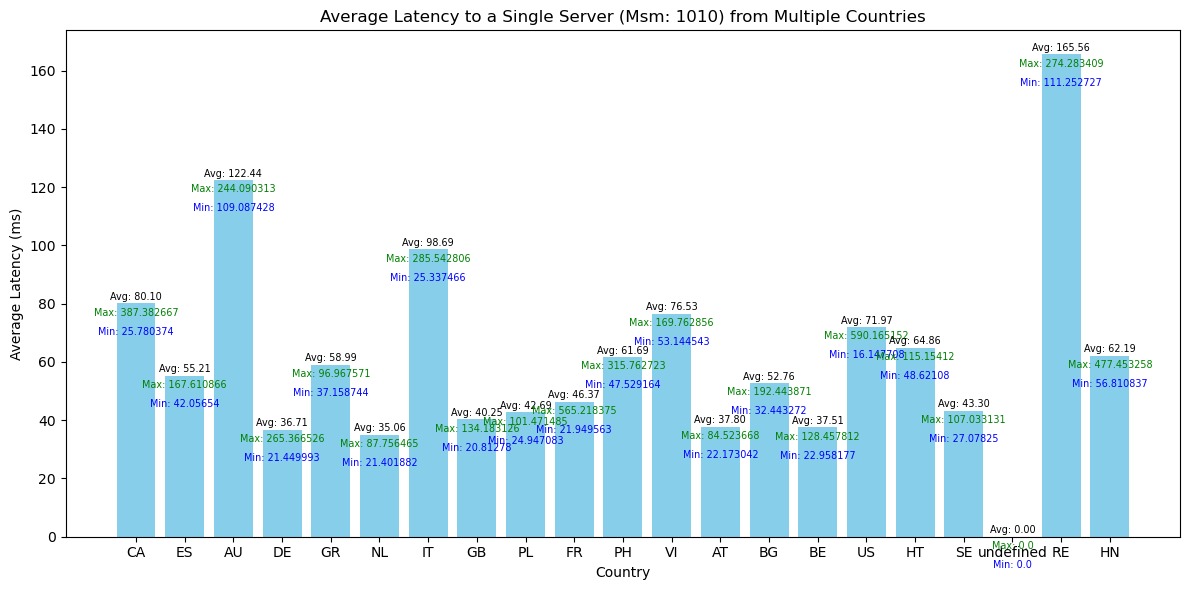

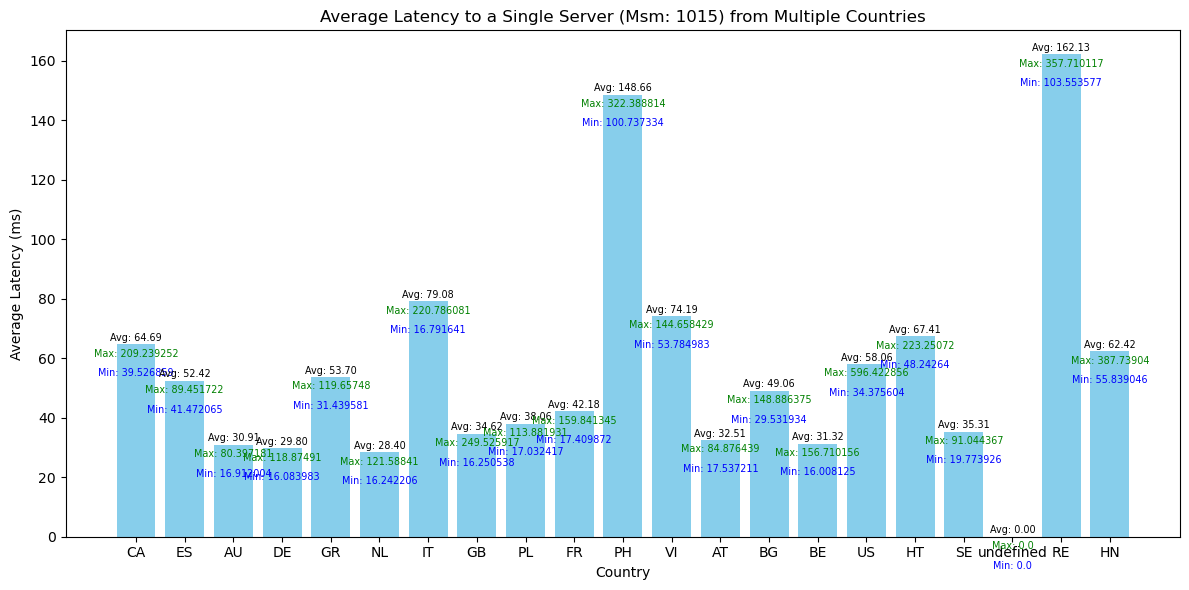

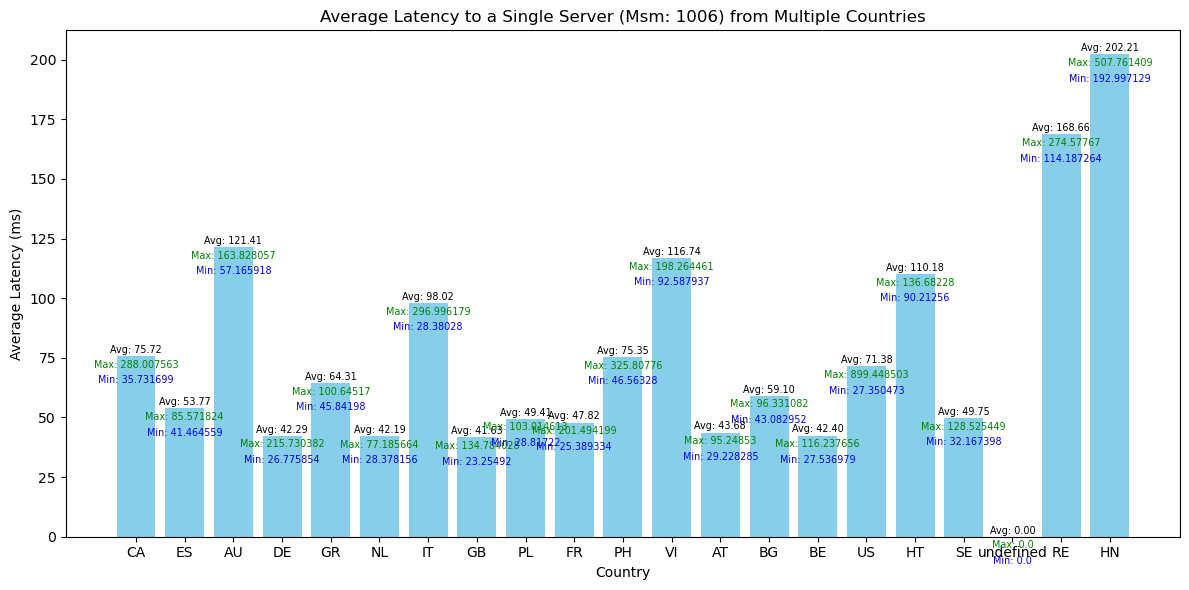

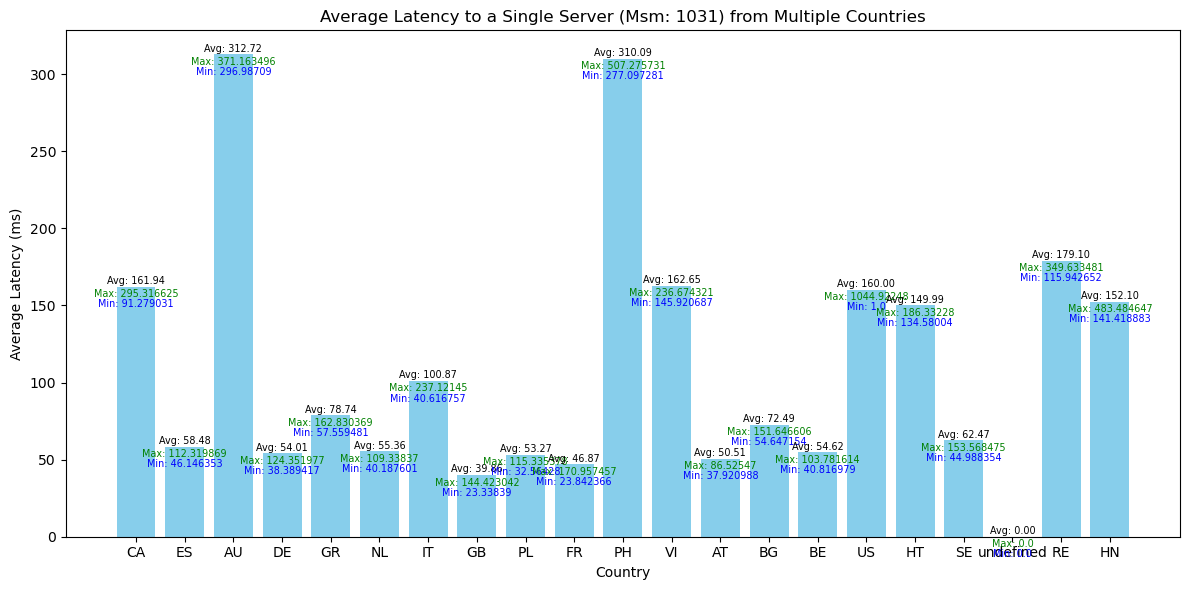

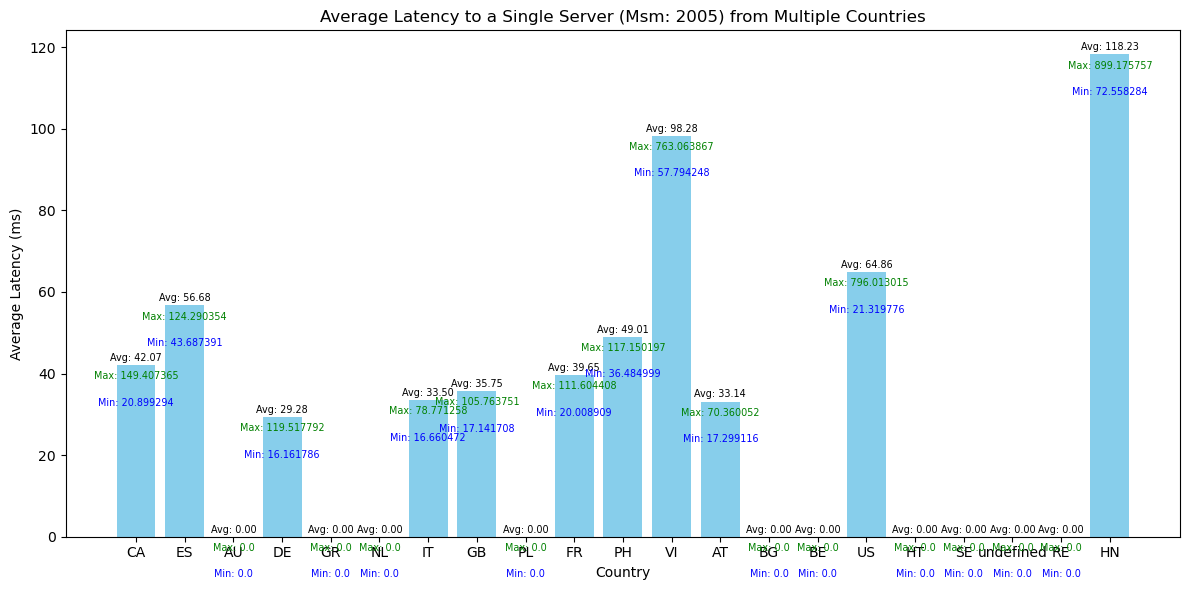

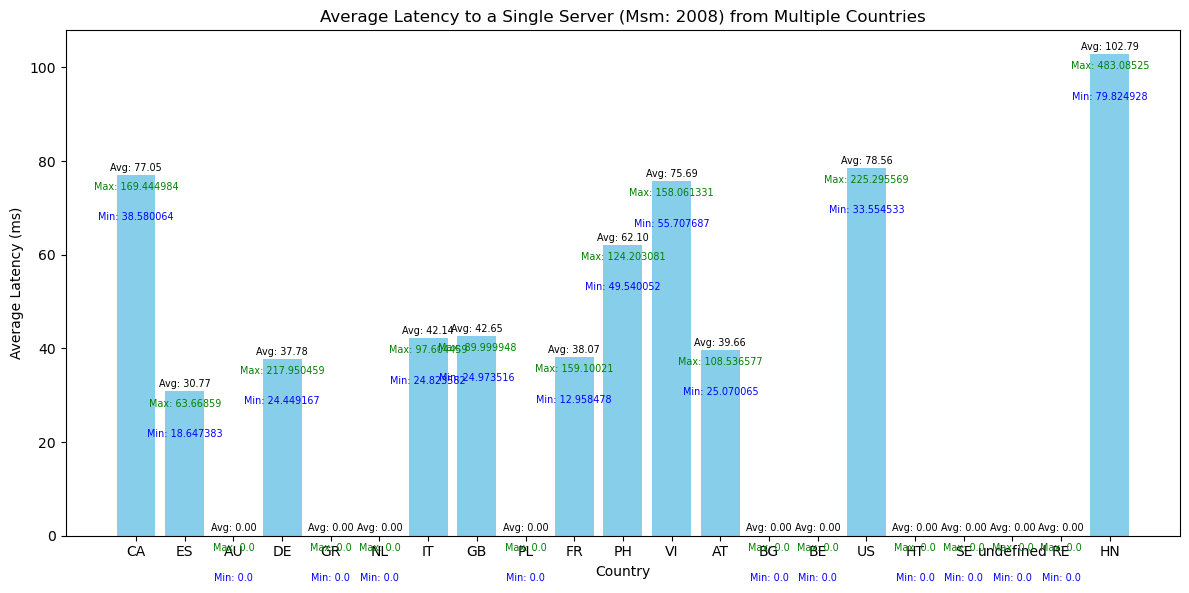

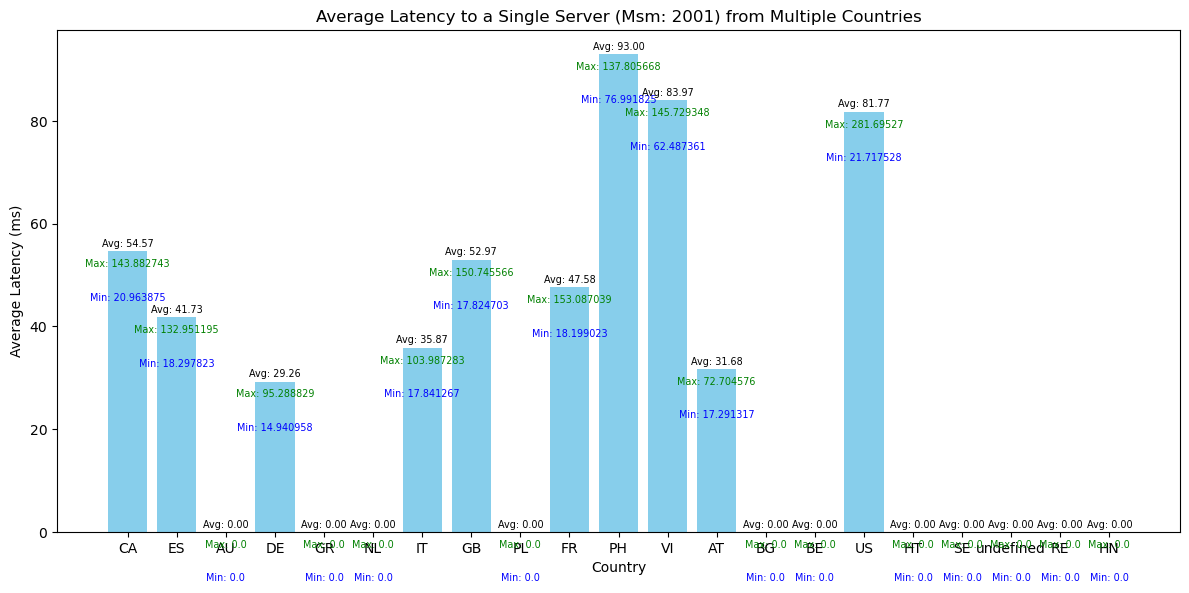

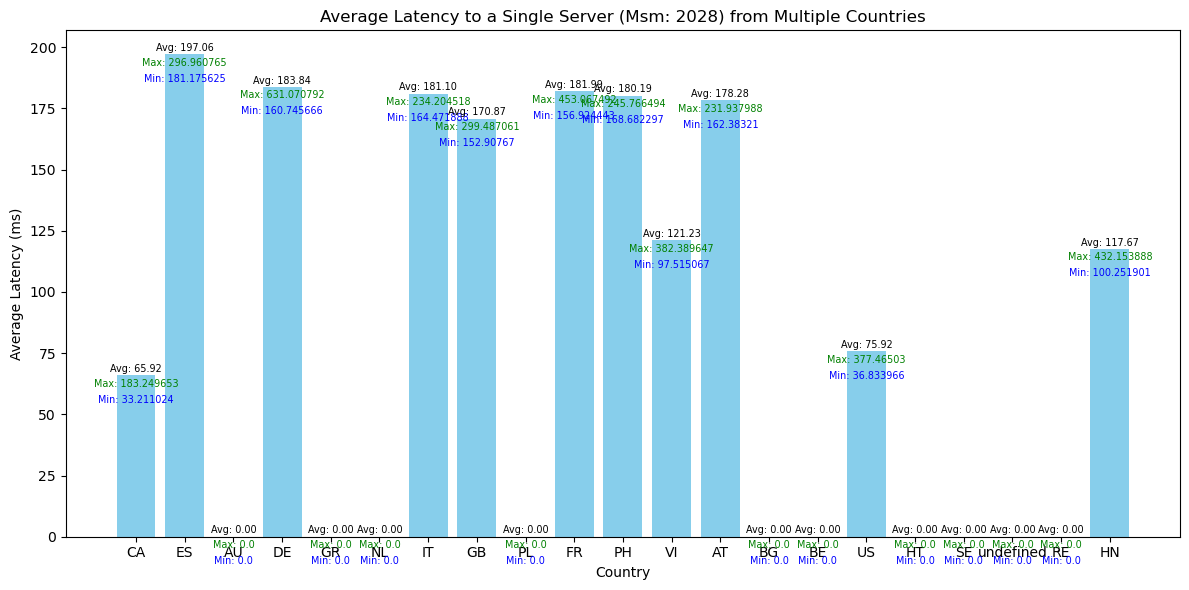

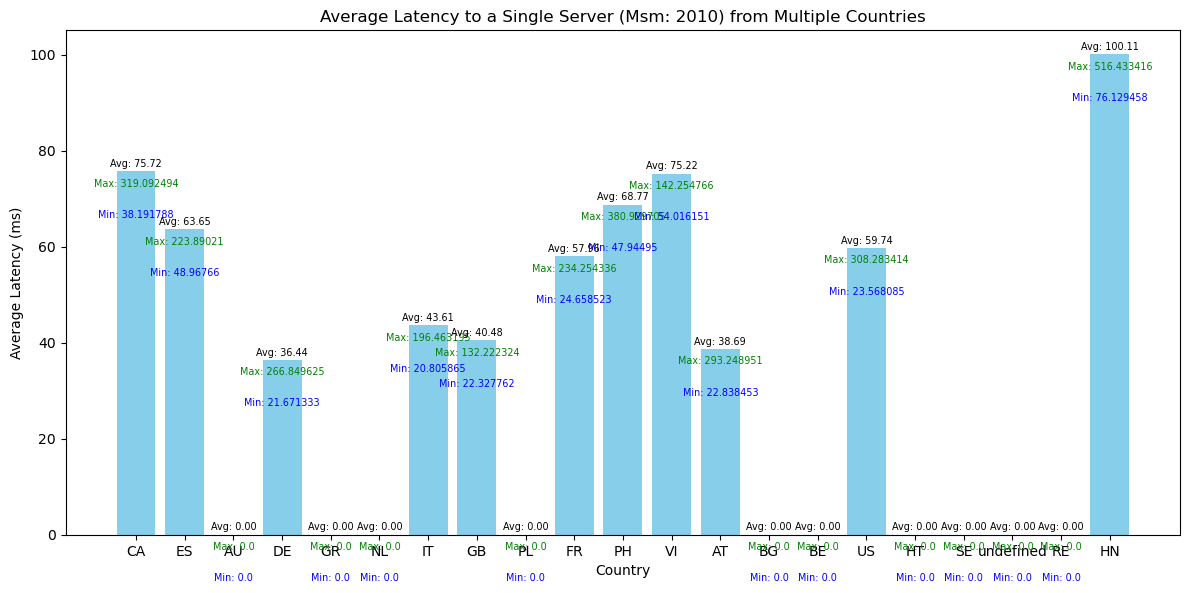

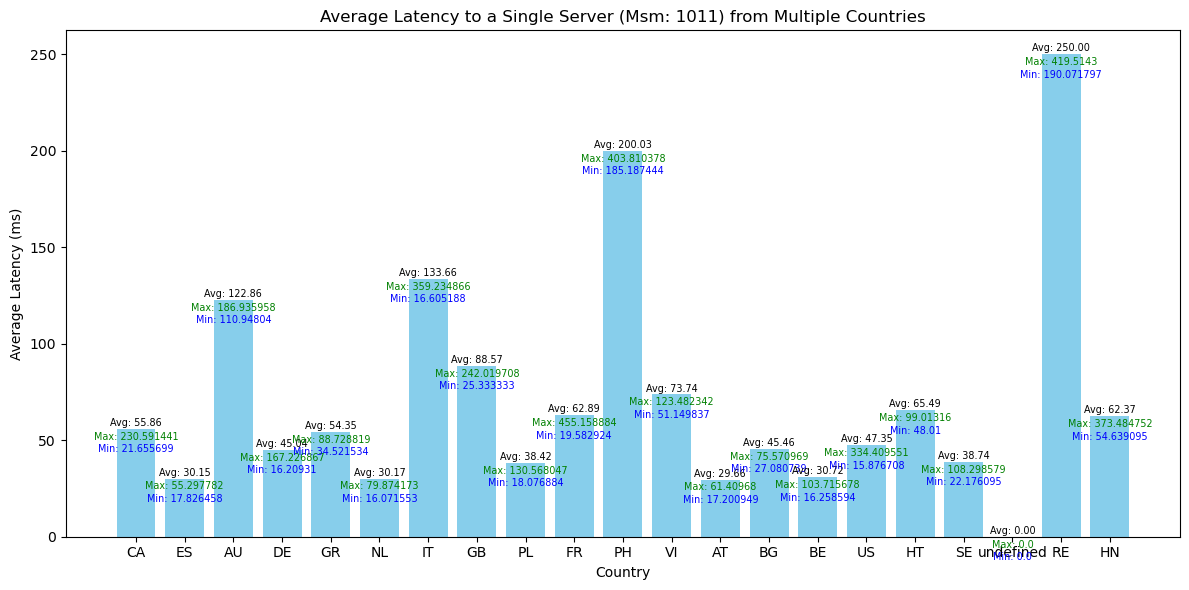

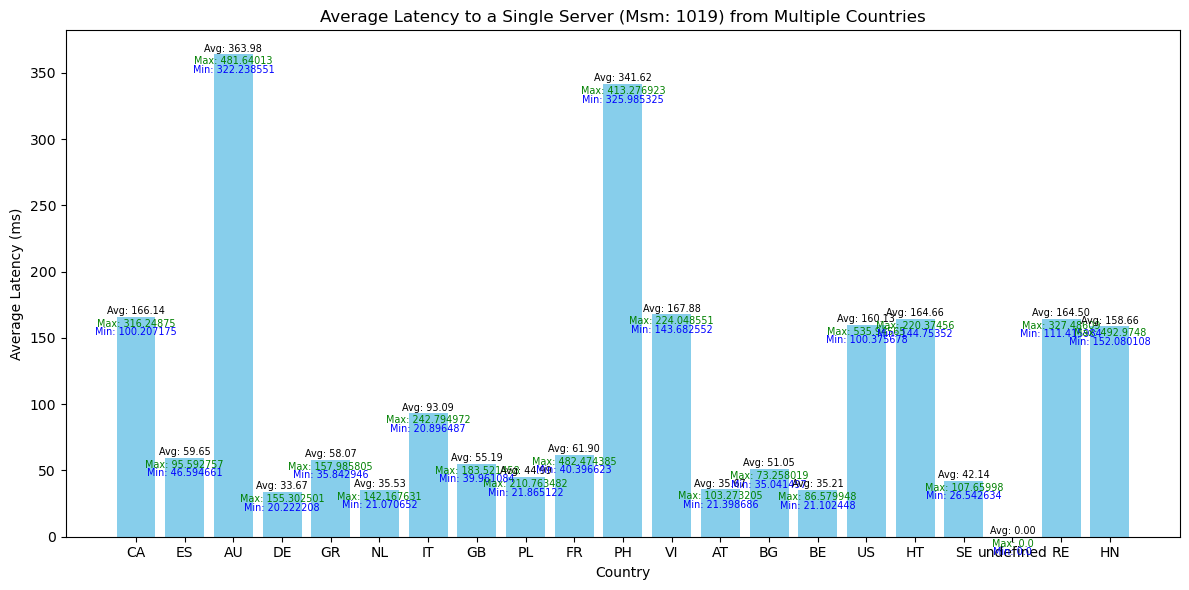

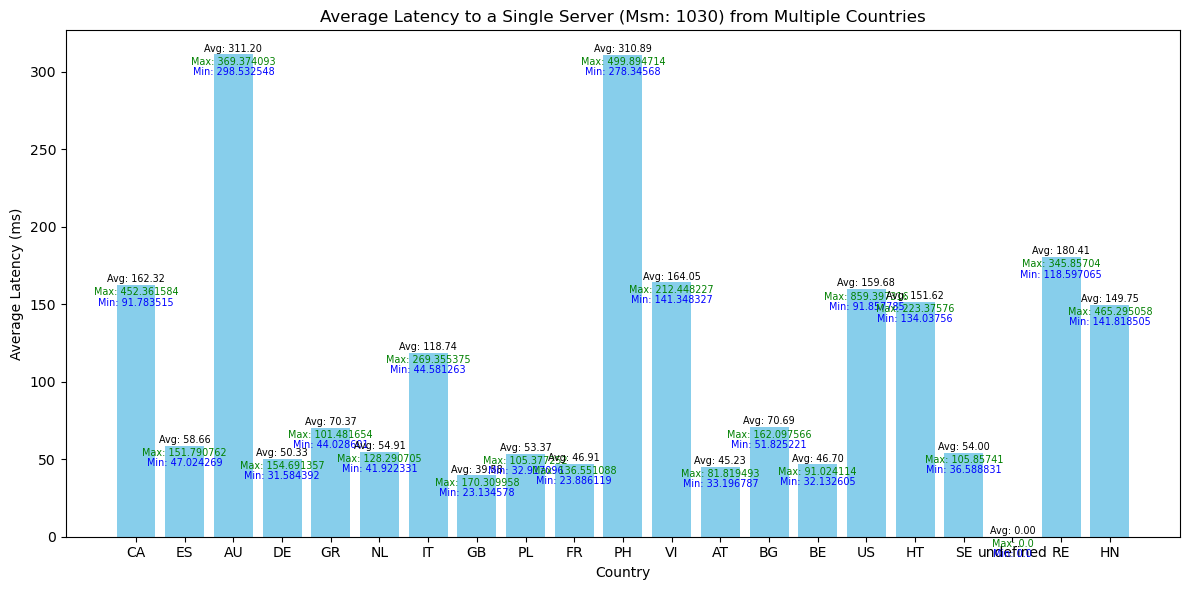

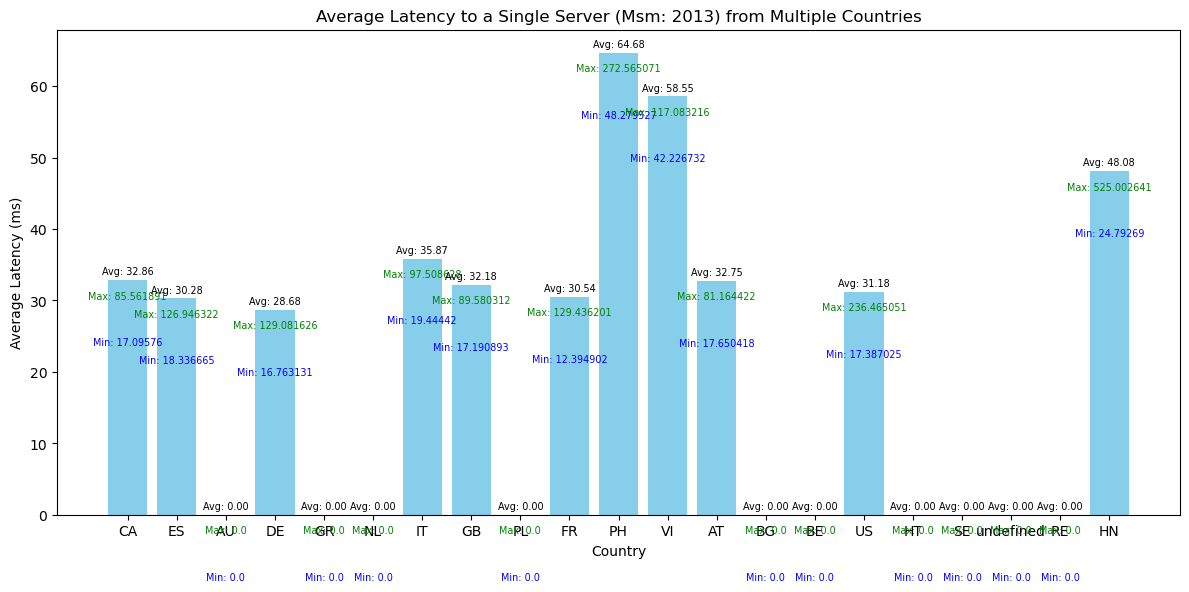

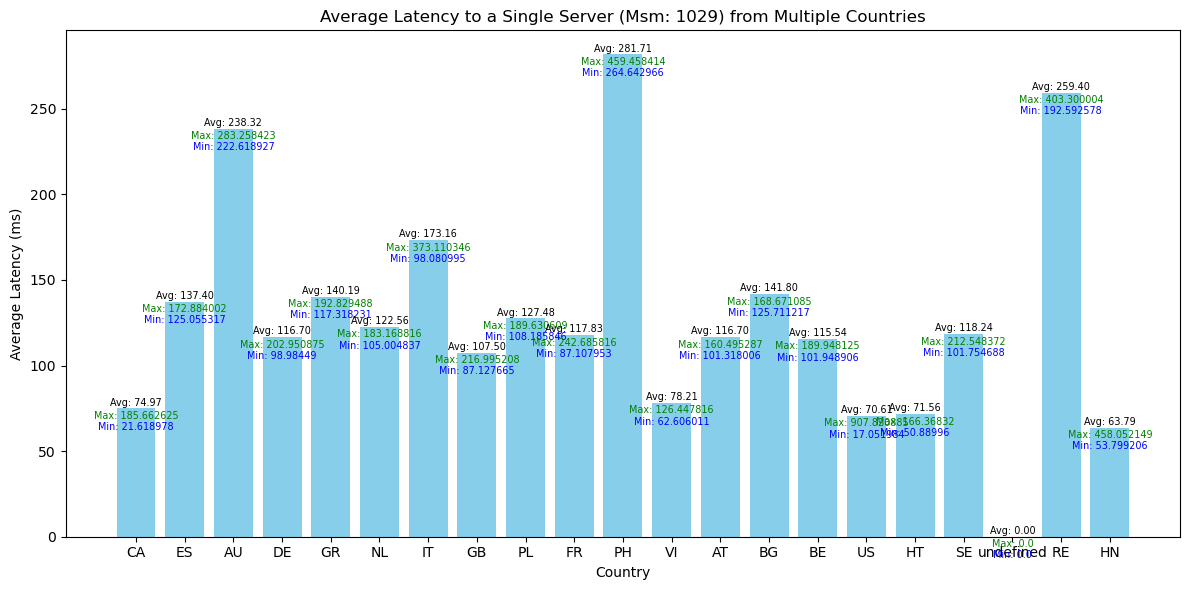

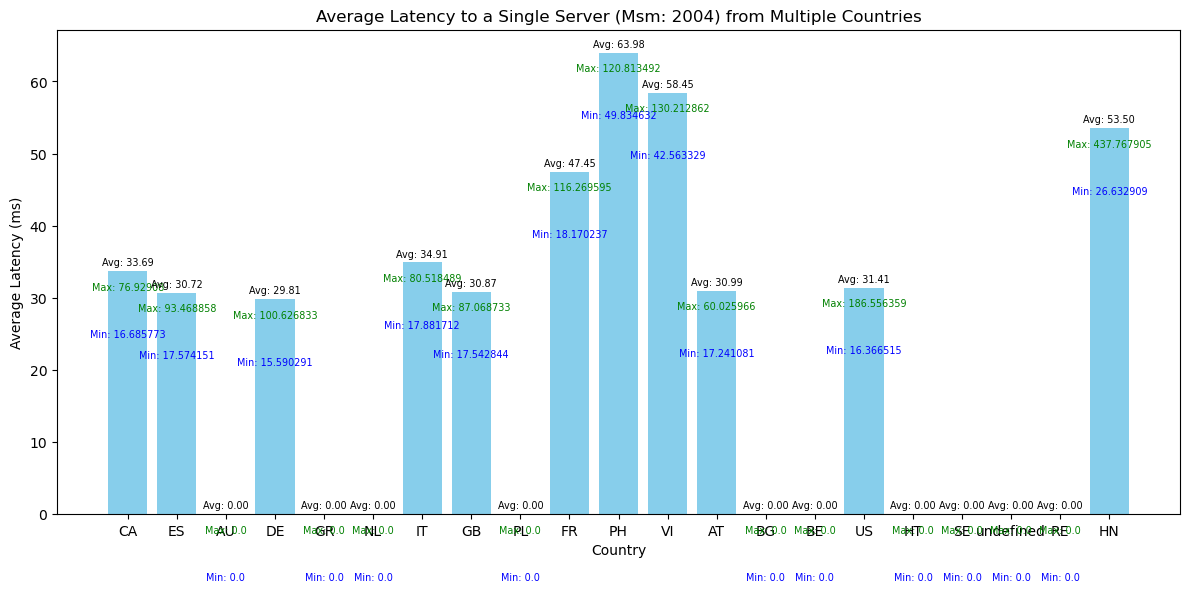

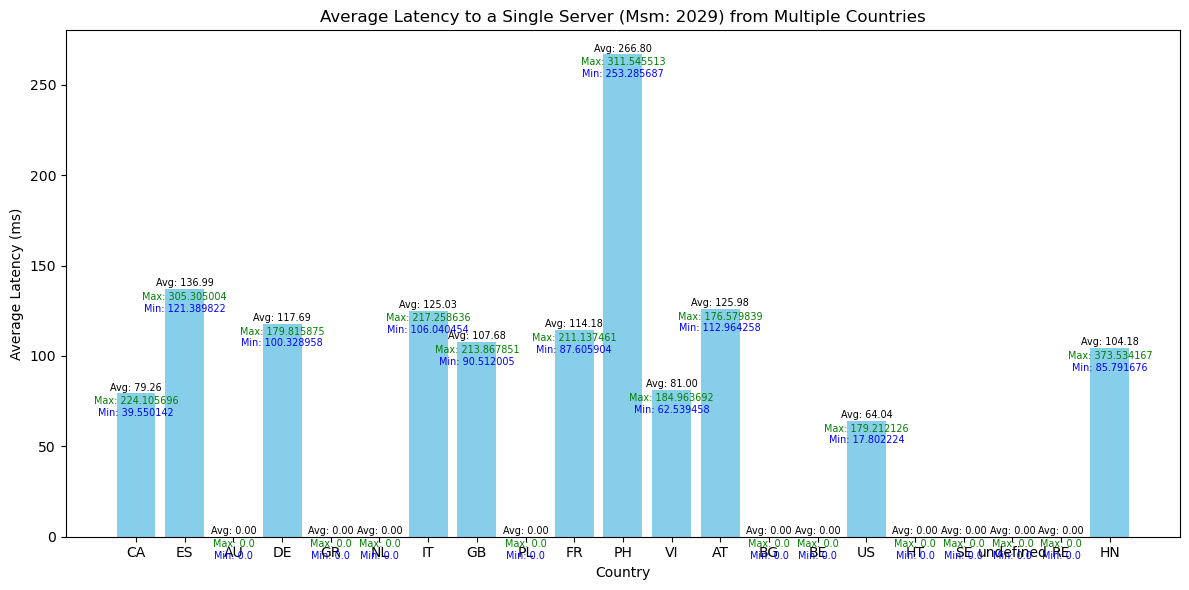

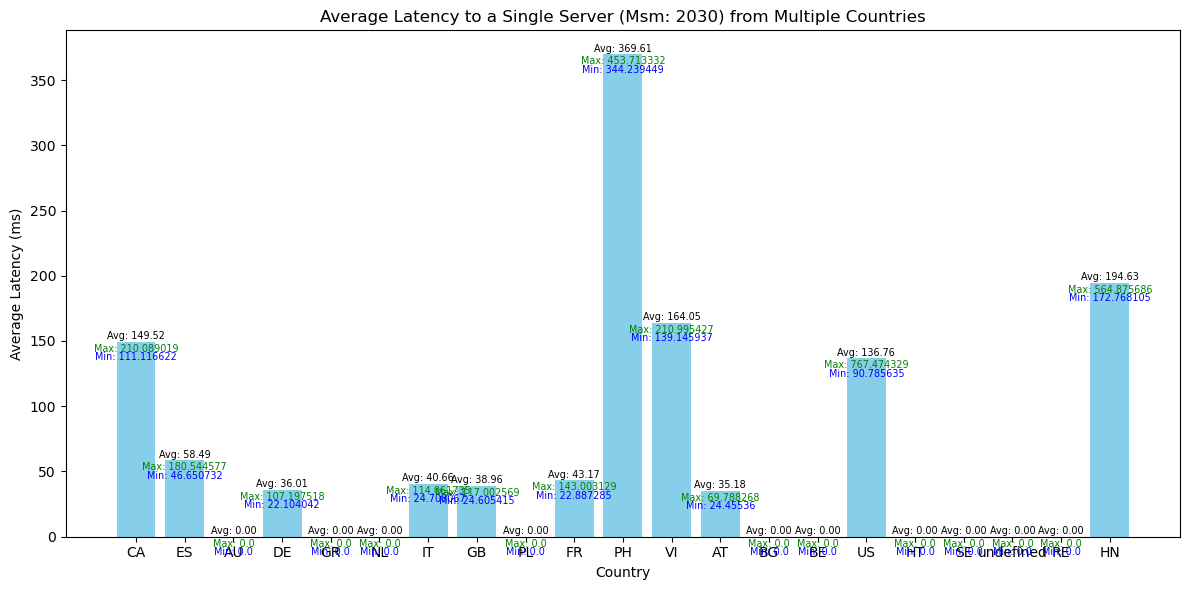

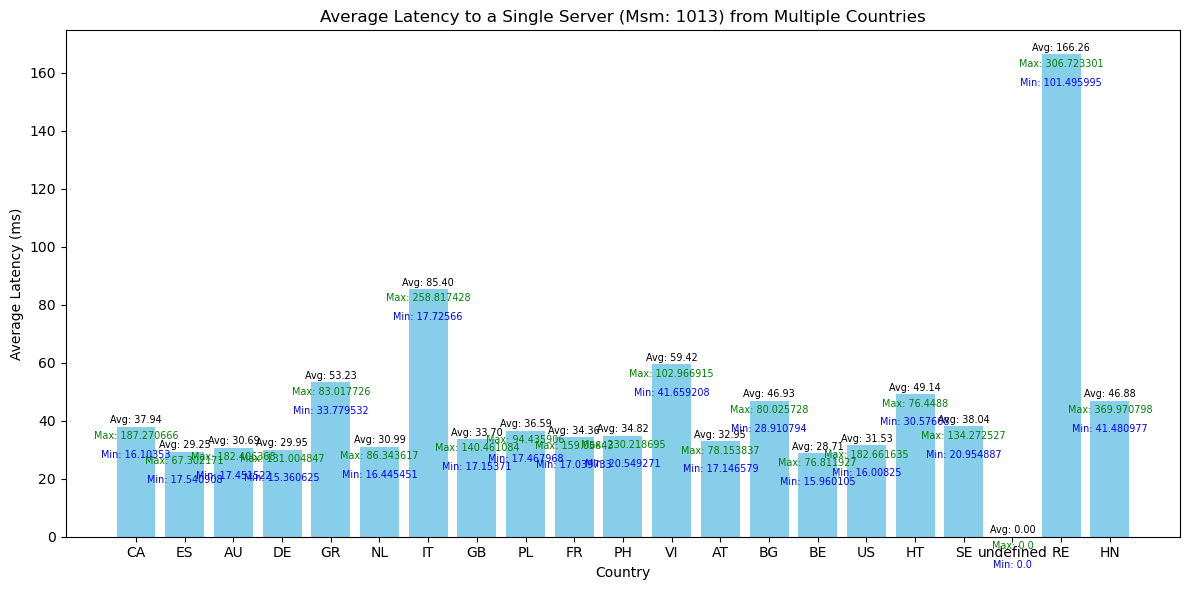

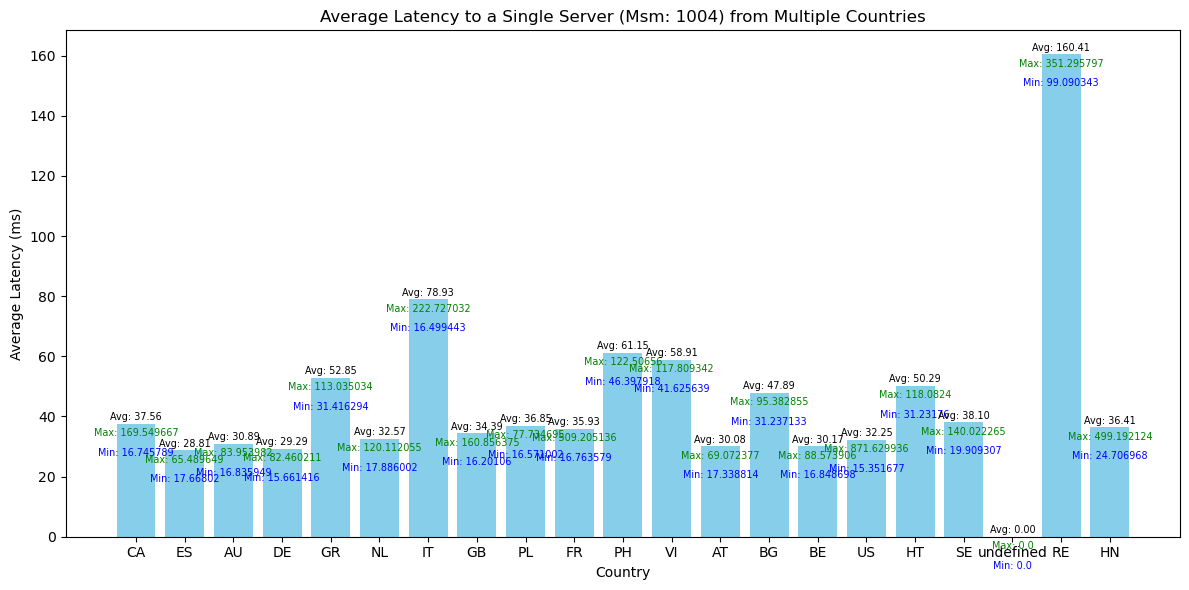

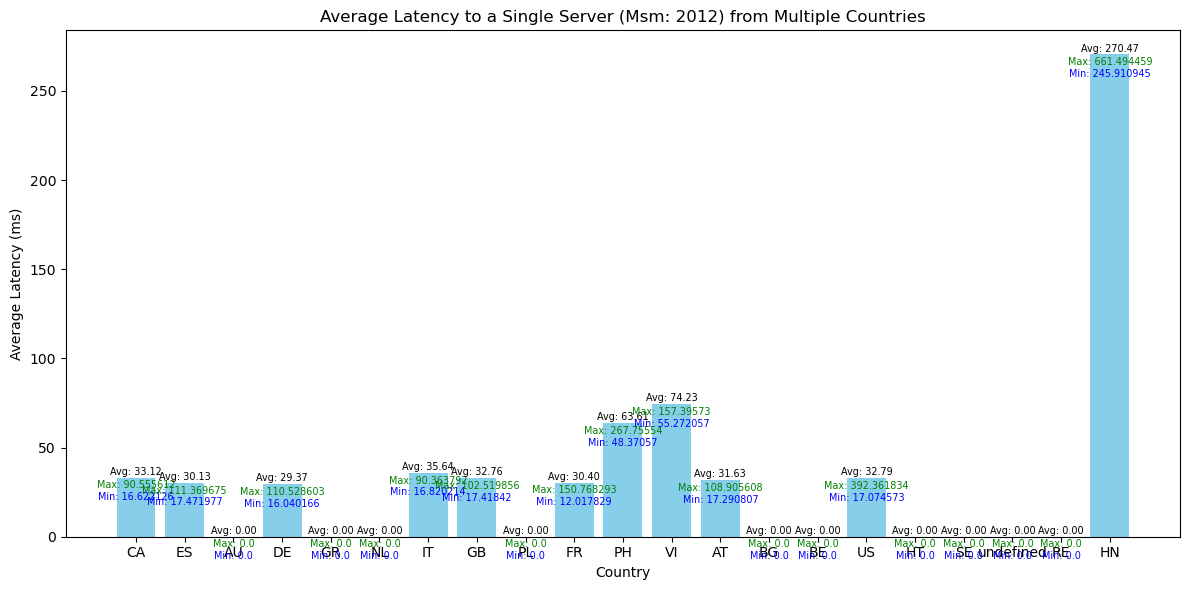

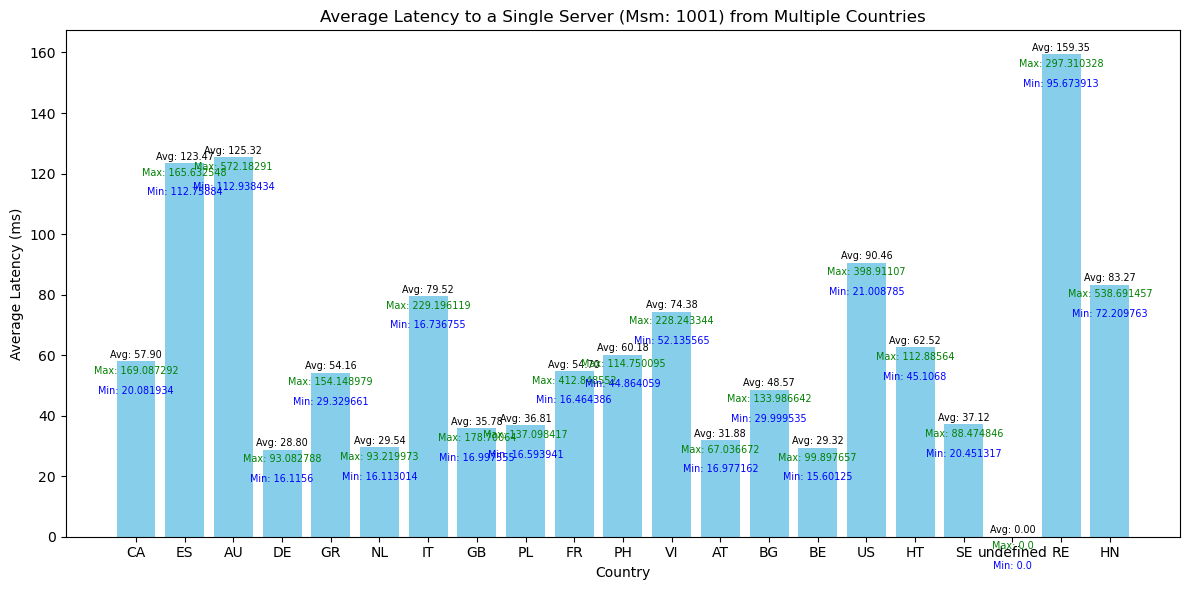

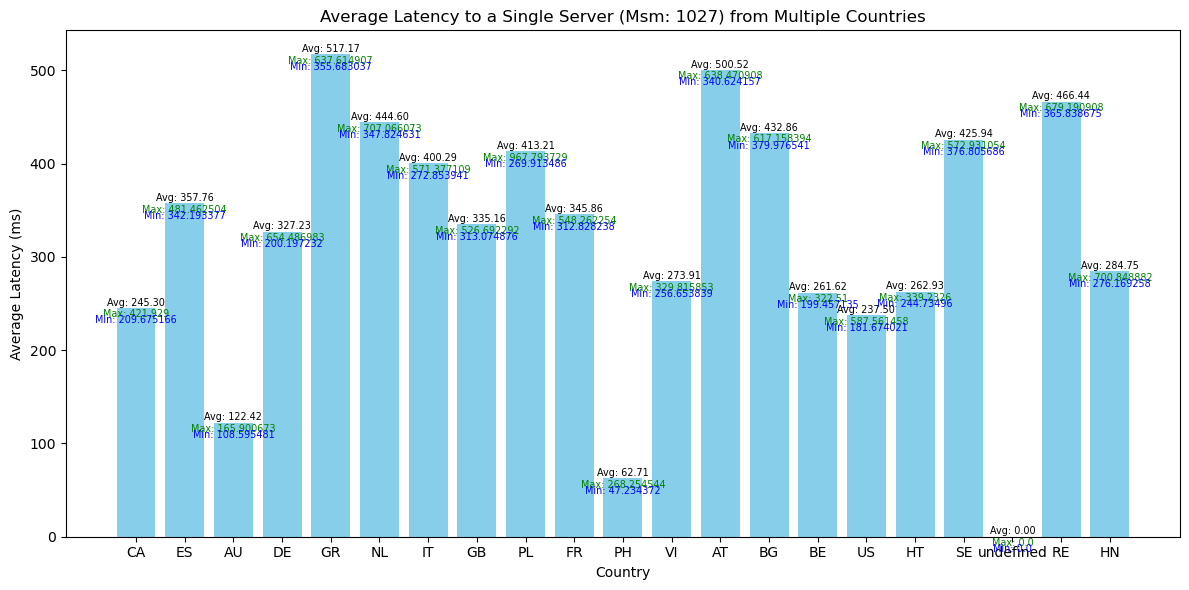

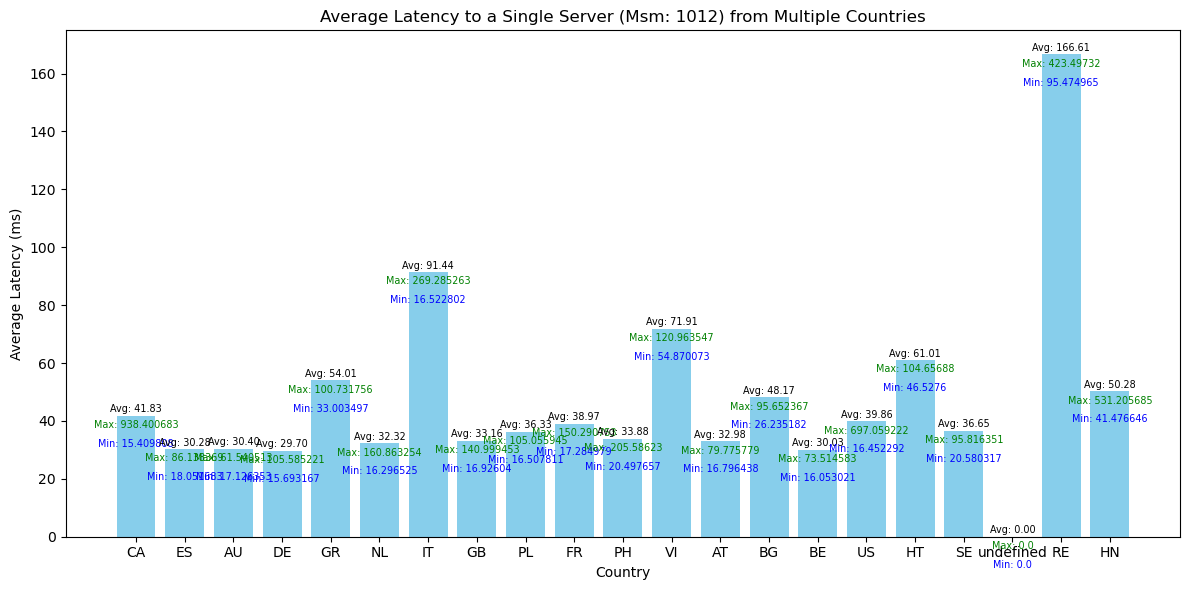

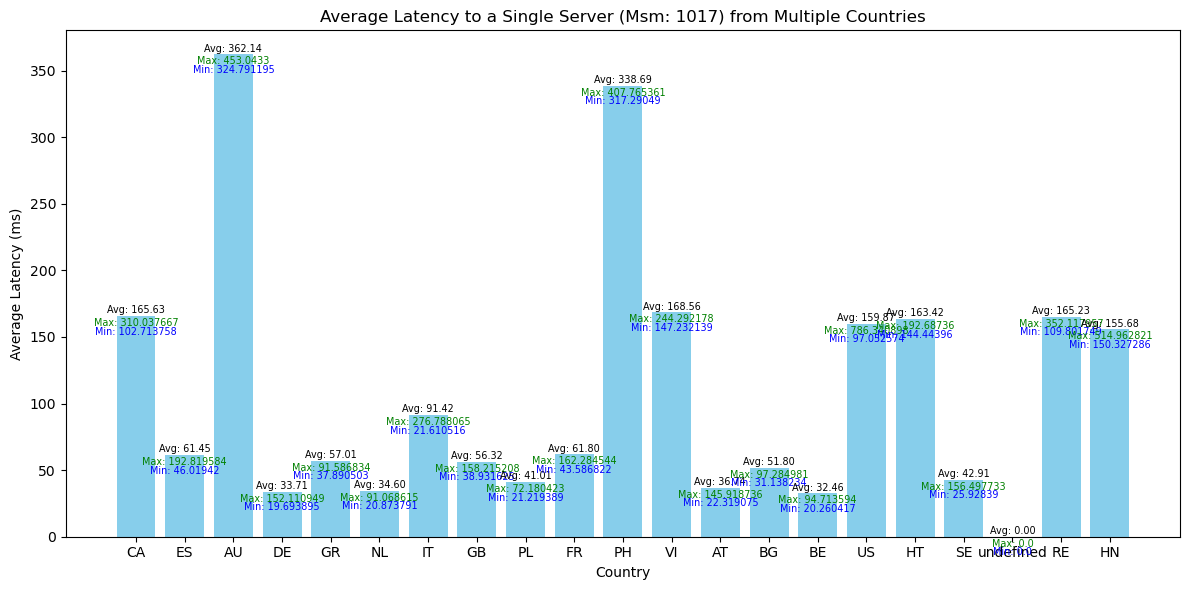

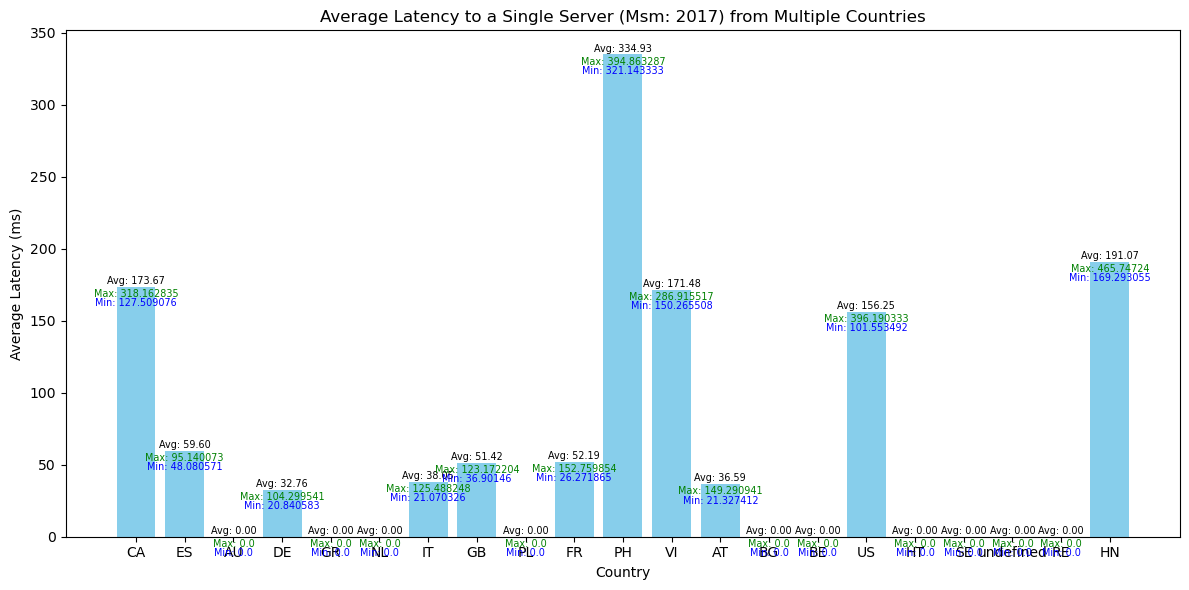

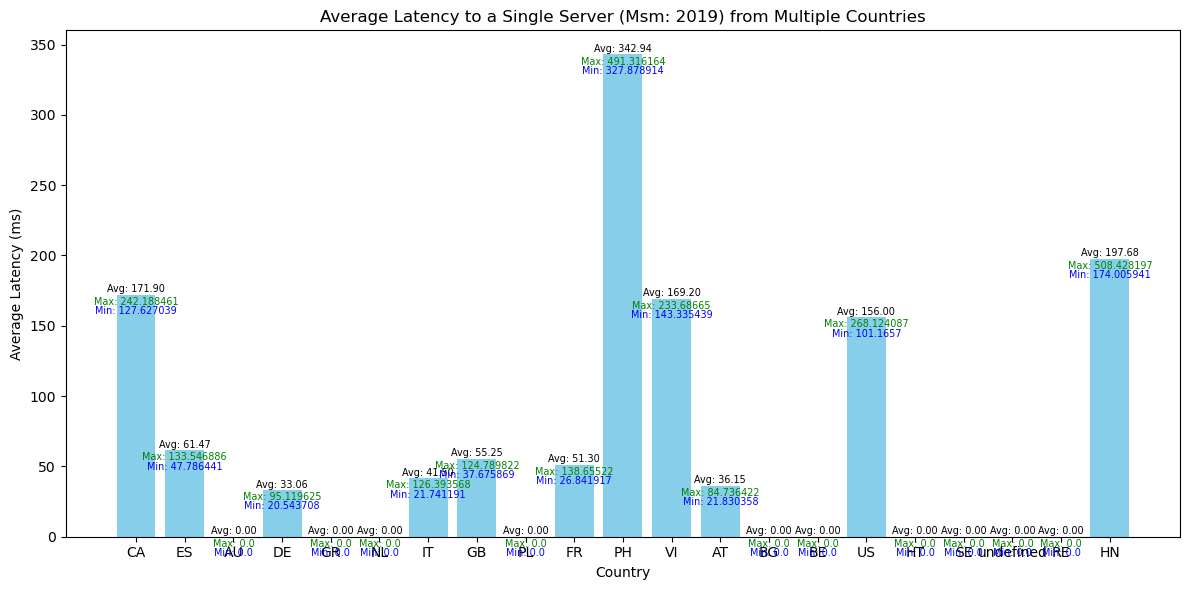

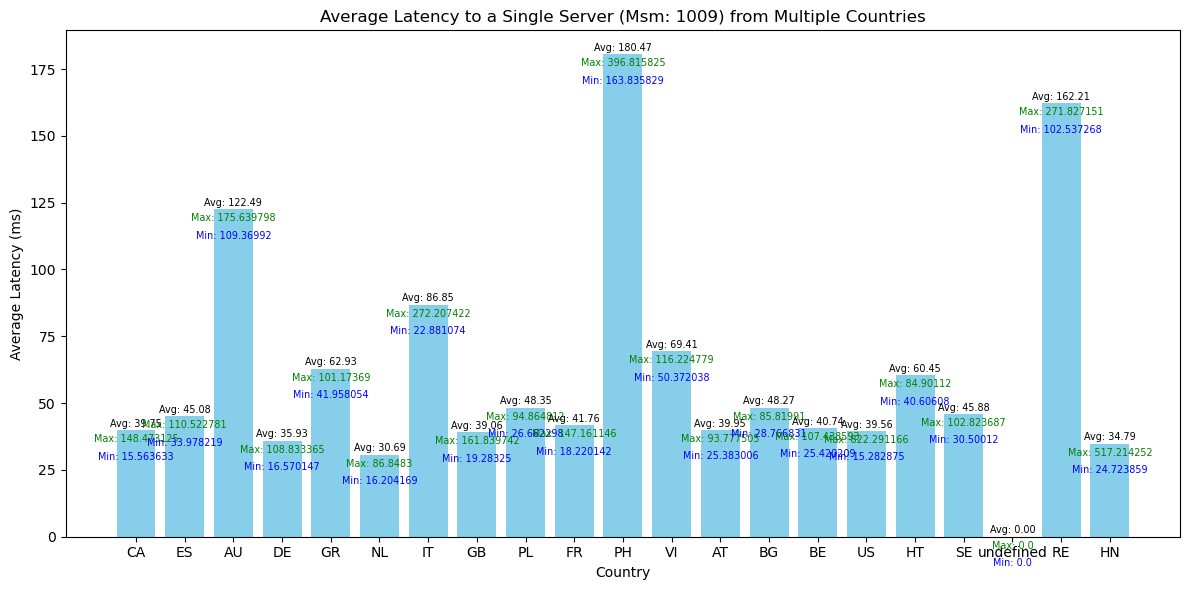

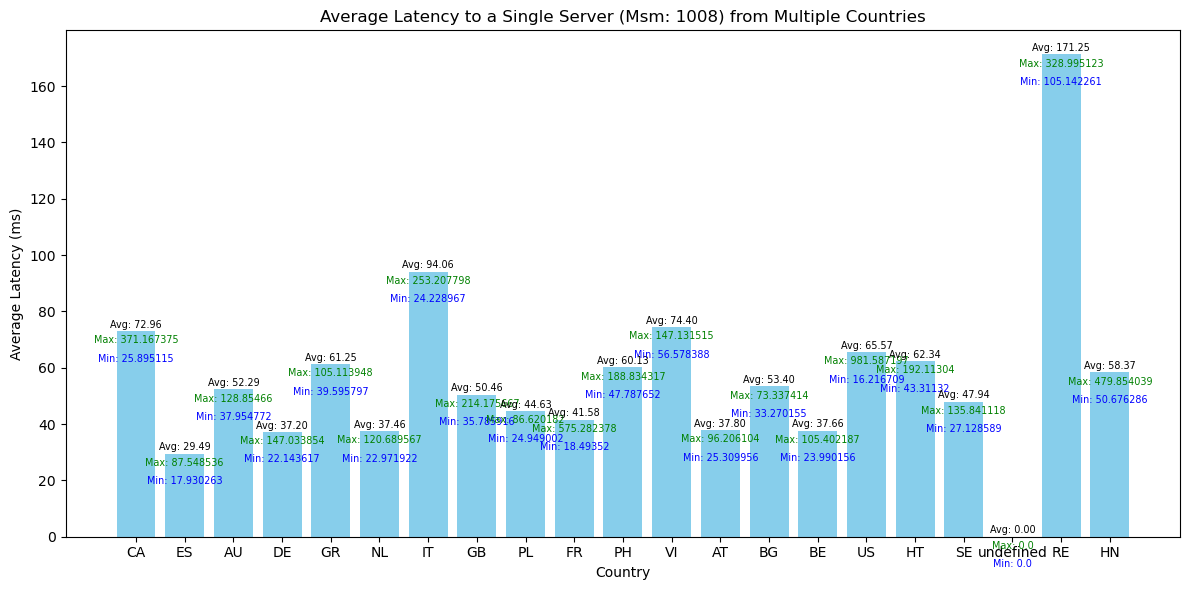

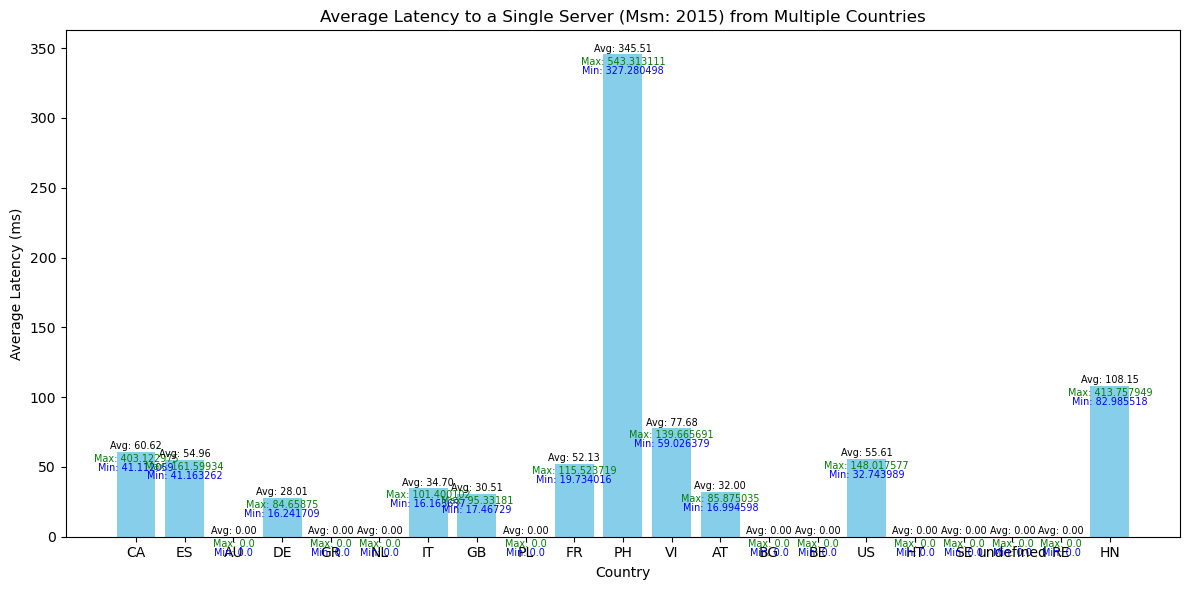

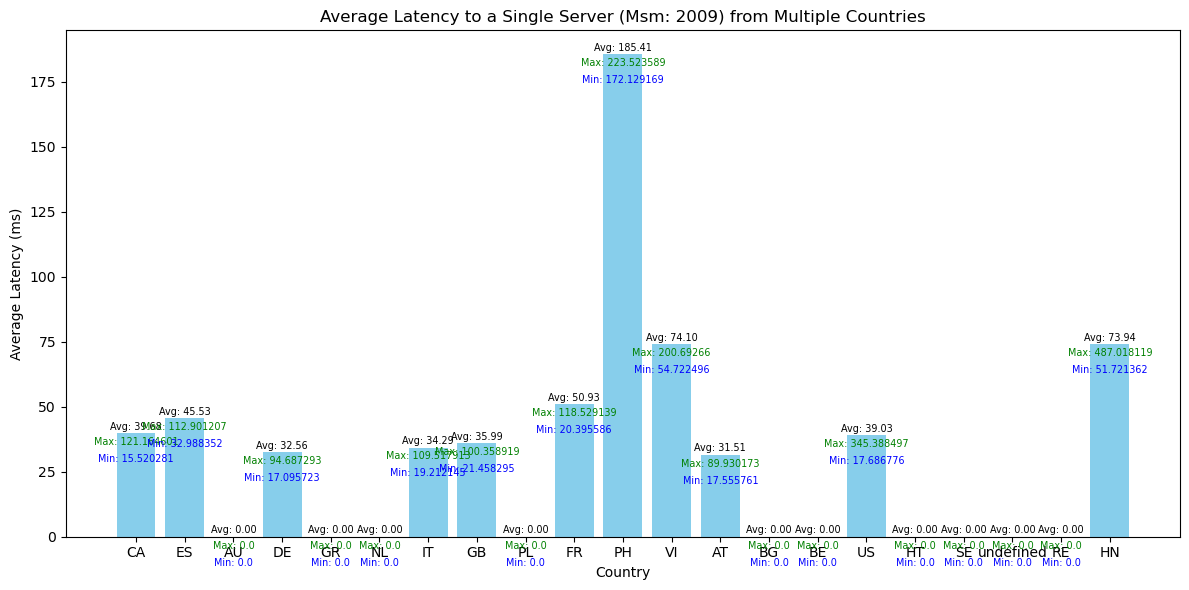

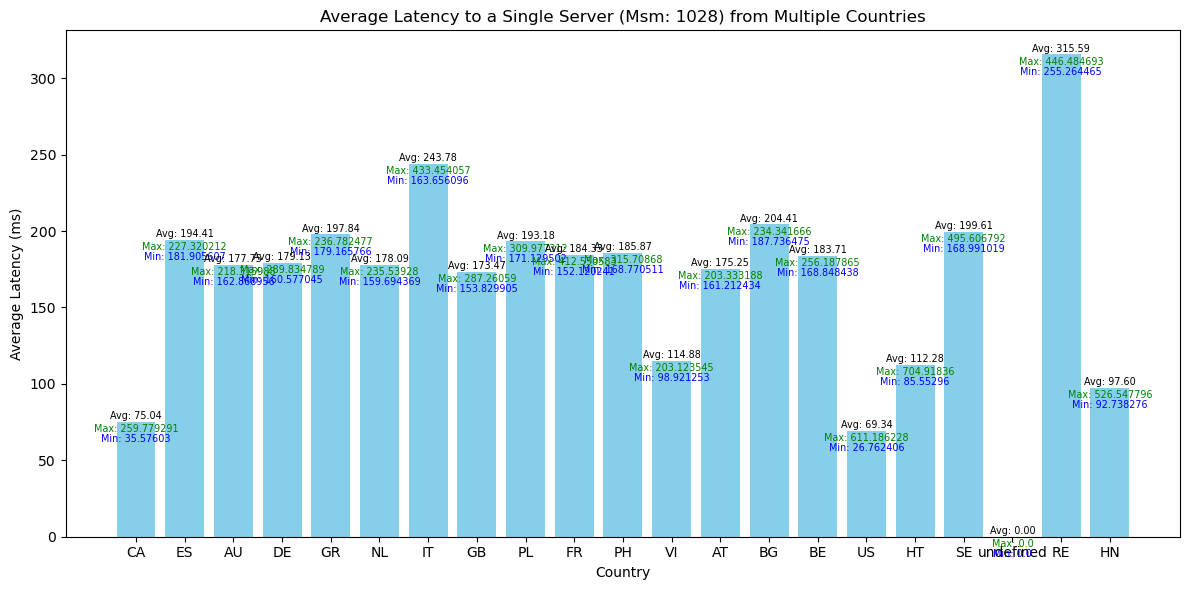

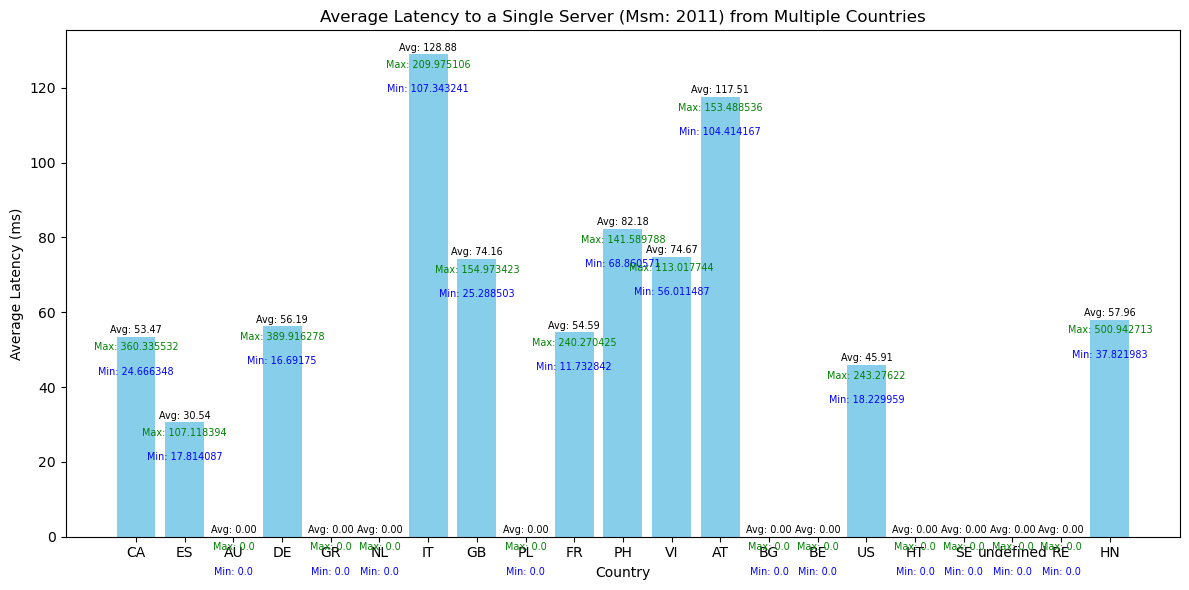

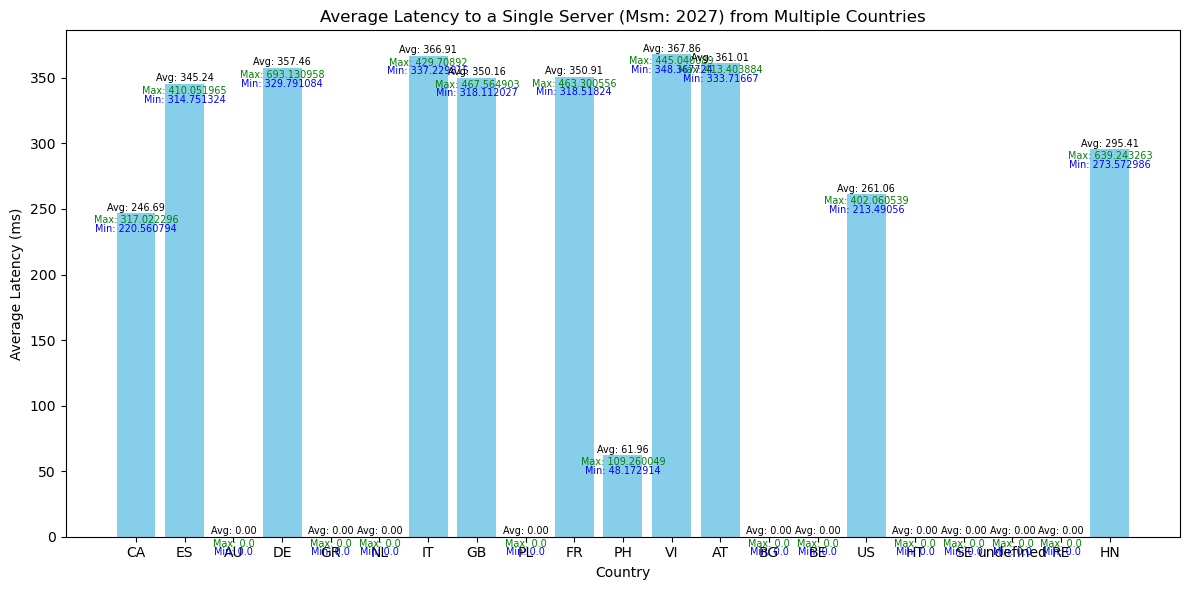

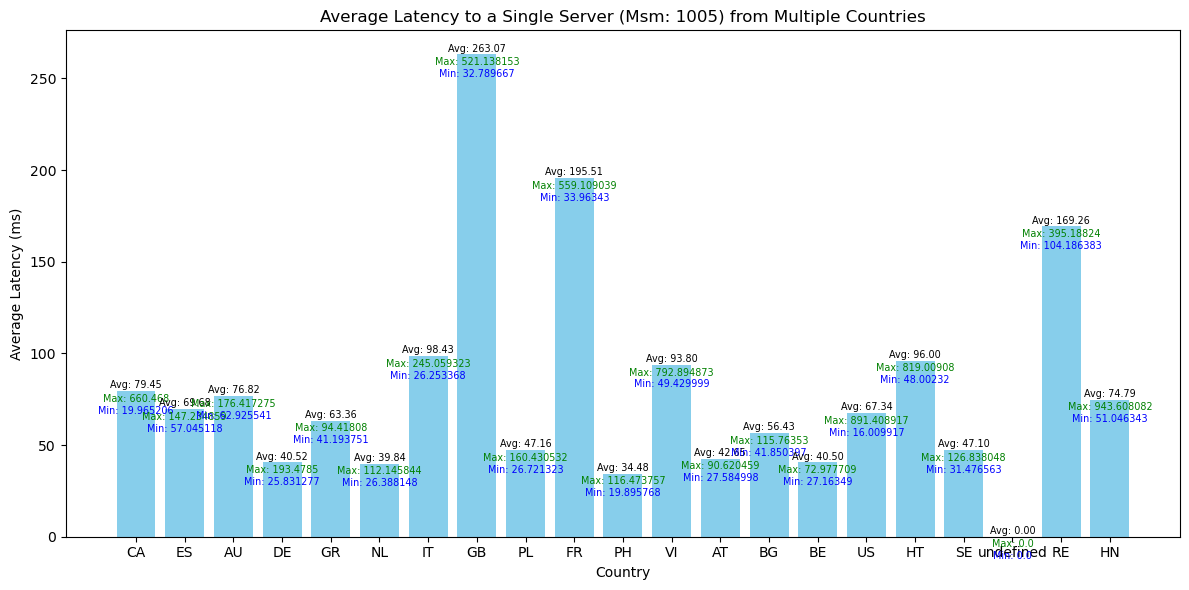

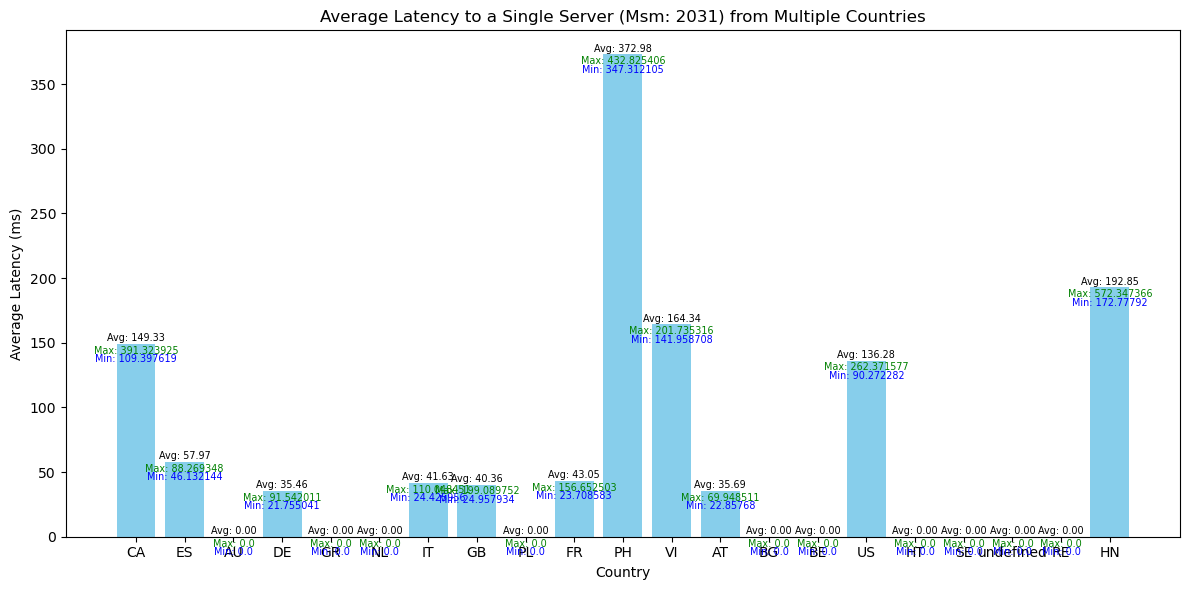

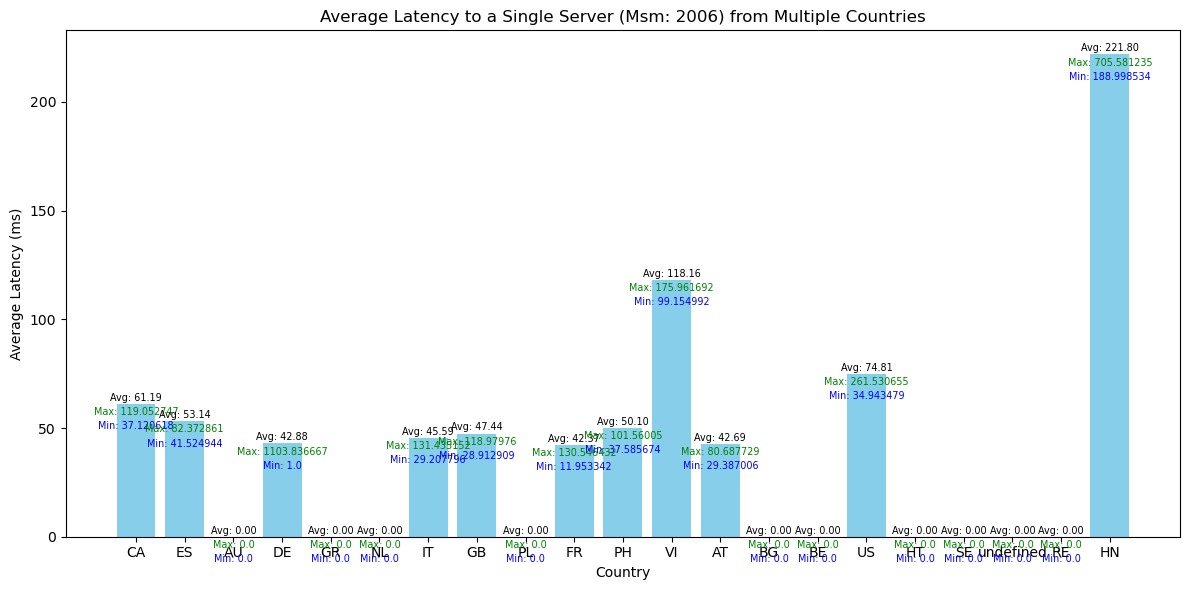

In [10]:
rtts = {}
def latency_by_country(country, msm_id):
    data = con.sql("SELECT result AS json, country FROM ping_data WHERE country = '" + country + "' AND msm_id = '" + str(msm_id) + "' AND result NOT LIKE '%*%' AND result NOT LIKE '%failed%';").df()    
    for point in data["json"]:
        l = json.loads(point)
        for e in l:
            o = e[next(iter(e))]
            if (o != "*"): rtts[msm_id][country].append(o)

for msm_id in built_in_msms:
    rtts[msm_id] = {}
    for c in countries:
        rtts[msm_id][c] = []
        latency_by_country(c, msm_id)

for msm in rtts:
    visualize_latencies(rtts[msm], msm)